# XGBoost (eXtreme Gradient Boosting) Model 

# Libraries 

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from datetime import *
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import *
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'
from xgboost import XGBRegressor
# %matplotlib inline

# Global Variables  

these are globale variables that are going to be used for model hyperparameter, training set, and validation set sizes
the size for training set is 20% simillarly validation size is 20%.

the rest of the variables are used for Model hyperparameter such as max tree depth max_depth=3, estimator number =100 which is Number of boosted trees to fit. we have also minimum loss reduction gamma =0.

In [2]:
test_size = 0.2                 # The percentage of the dataset allocated for use as the test set
cv_size = 0.2                   # The percentage of the dataset allocated for use as cross-validation set
N = 3                           # for feature at day t, we use lags from t-1, t-2, ..., t-N as features                                   
n_estimators = 100              # default number of boosted trees to fit.
max_depth = 3                   # default Maximum tree depth for base learners.
learning_rate = 0.1             # Boosting learning rate (xgb’s “eta”). 
min_child_weight = 1            # default Minimum sum of instance weight(hessian) needed in a child.
subsample = 1                   # default Subsample ratio of the training instance.
colsample_bytree = 1            # default Subsample ratio of columns when constructing each tree.
colsample_bylevel = 1           # default Subsample ratio of columns for each split, in each level.
gamma = 0                       # default minimum loss reduction required to make a further partition on a leaf node of the tree.
model_seed = 100                # model seed

In [3]:
# test_size = 0.2                 # proportion of dataset to be used as test set
# cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
# Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
# test_size = 0.2                 ## proportion of dataset to be used as test set                               
# cv_size = 0.2                   # proportion of dataset to be used as cross-validation set                                
# N = 3                           # for feature at day t, we use lags from t-1, t-2, ..., t-N as features                                   
# n_estimators = 100              # Number of boosted trees to fit. default = 100
# max_depth = 3                   # Maximum tree depth for base learners. default = 3
# learning_rate = 0.1             # Boosting learning rate (xgb’s “eta”). default = 0.1
# min_child_weight = 1            # Minimum sum of instance weight(hessian) needed in a child. default = 1
# subsample = 1                   # Subsample ratio of the training instance. default = 1
# colsample_bytree = 1            # Subsample ratio of columns when constructing each tree. default = 1
# colsample_bylevel = 1           # Subsample ratio of columns for each split, in each level. default = 1
# gamma = 0                       # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0
# model_seed = 100                             # Nmax is the maximum N we are going to test

# Assistant  functions

Before loading dataset, I have created some functions to be used later for instance, stock price movment based on specific col.
this function will compute the mean and stander diviation for a col then it will create new cols for mean and std for that col.

**row_scaling:** is used to scale row based on mean and std to reduce the bigger values in the dataset before passing them into model for trining. this help to increase model performance.

**get_mape:** Compute mean absolute percentage error (MAPE)

**model_train_pred_eval:** the last function is used to train and evaluate model based on its hyperparametrs. Also its used for training and prediction processes. the function takes model hyperparameters and training, testing datasets. it will return the predected data with RMSE(root mean square error), MAPE(mean absolute percentage error of), and model accuracy.

In [4]:
def col_mean_std(df, col, N):
    mean_list = df[col].rolling(window = N, min_periods=1).mean() 
    std_list = df[col].rolling(window = N, min_periods=1).std()   
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    return df_out

def row_scaling(row, feat_mean, feat_std):
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    row_scaled = (row-feat_mean) / feat_std
    return row_scaled

def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    

def model_train_pred_eval(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model and get predicted labels then scale labels to original values
    model.fit(X_train_scaled, y_train_scaled)
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean
    
    #calculate metrics MAE,MSE,RMSE,mape
    mae = mean_absolute_error(y_test,est)
    mse = mean_squared_error(y_test, est)
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    accuracy = r2_score(y_test,est)
    return mse,mae,rmse, mape,accuracy, est

# Loading dataset from Yahoo Finance

Now I will download the dataset from Yahoo! Finance API by using the lib 'yfinance'. it helps to download historical dataset of stock prices based on specific dates. for our dataset I'm using Apple stock market from 2010 to 2020. then I will rename Adj close column to be adj_close. after that I have created new column for month which is going to be cacluated based on column date. as shown in the table this is the dataset for Apple from 2010 to 2020.

In [5]:
# set company name and start and end date
company_name = 'AAPL'
start = "2010-01-01"
end = "2020-03-31"
df = yf.download(company_name, start, end)
df['date']=df.index
df=df.reset_index(drop=True)
# convert all columns to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
# Get month of each sample
df['month'] = df['date'].dt.month
# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)
df.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj_close,volume,date,month
0,7.622500,7.660714,7.585000,7.643214,6.496295,493729600,2010-01-04,1
1,7.664286,7.699643,7.616071,7.656429,6.507525,601904800,2010-01-05,1
2,7.656429,7.686786,7.526786,7.534643,6.404016,552160000,2010-01-06,1
3,7.562500,7.571429,7.466071,7.520714,6.392174,477131200,2010-01-07,1
4,7.510714,7.571429,7.466429,7.570714,6.434673,447610800,2010-01-08,1


# Plot adjusted close

To visualize the close prices to get better idea about trends and its behaviour. I'm using matplot lib for visualization.

Text(0, 0.5, 'USD')

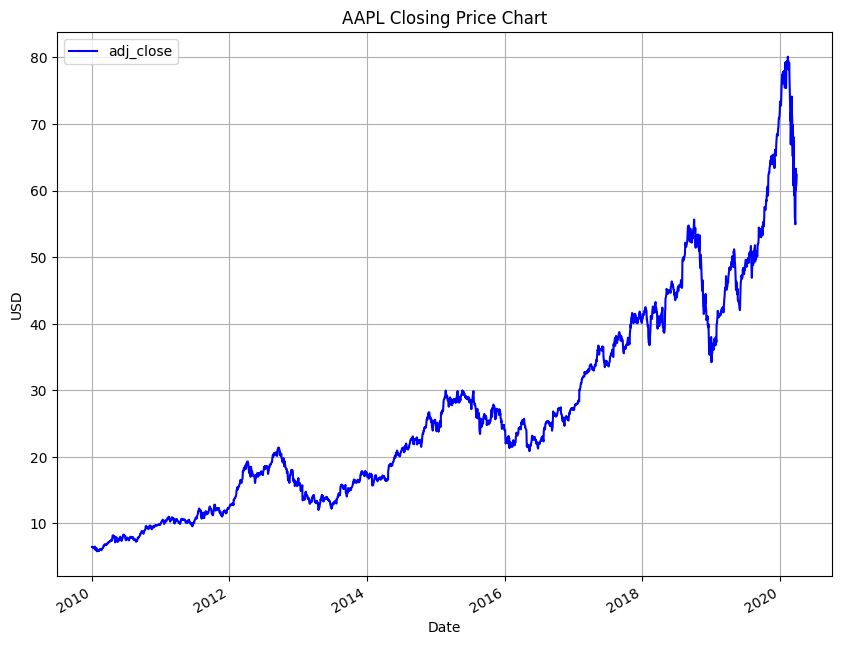

In [7]:
# width,height
rcParams['figure.figsize'] = 10, 8 
ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_title(company_name + ' Closing Price Chart')
ax.set_ylabel("USD")

# Feature Engineering
I'm using new featuer before training model which are the diffrences between high and low prices and open and close prices.
Get difference between high and low prices of each day and save it in new column 'range_hl' (rande_high_low)
then
Get difference between open and close prices of each day and save it in new column 'range_oc' (range open_close).

In [8]:
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)
df.head()

,adj_close,volume,date,month,range_hl,range_oc
0,6.496295,493729600,2010-01-04,1,0.075714,-0.020714
1,6.507525,601904800,2010-01-05,1,0.083572,0.007857
2,6.404016,552160000,2010-01-06,1,0.160000,0.121786
3,6.392174,477131200,2010-01-07,1,0.105358,0.041786
4,6.434673,447610800,2010-01-08,1,0.105000,-0.060000


Then I have converted date column to be series number and save new values in new column 'order_day' which is the replacment of Date column. Then I show list of columns that we will use to create lags.

In [9]:
df['order_day'] = [x for x in list(range(len(df)))]
print(df.head())
merging_keys = ['order_day']
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

   adj_close     volume       date  month  range_hl  range_oc  order_day
0   6.496295  493729600 2010-01-04      1  0.075714 -0.020714          0
1   6.507525  601904800 2010-01-05      1  0.083572  0.007857          1
2   6.404016  552160000 2010-01-06      1  0.160000  0.121786          2
3   6.392174  477131200 2010-01-07      1  0.105358  0.041786          3
4   6.434673  447610800 2010-01-08      1  0.105000 -0.060000          4


['adj_close', 'range_hl', 'range_oc', 'volume']

Time series forecasting can be framed as a supervised learning problem by using Sliding Window technique. Given a sequence of numbers for a time series dataset, we can restructure the data to look like a supervised learning problem. We can do this by using previous time steps as input variables and use the next time step as the output variable. the shift() function can be used to create copies of columns that are pushed forward  or pulled back.

This is the behavior required to create columns of lag observations as well as columns of forecast observations for a time series dataset in a supervised learning format.

In [10]:
shift_range = [x+1 for x in range(N)]
for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    train_shift['order_day'] = train_shift['order_day'] + shift
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)
    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
print(train_shift.head())
del train_shift
df = df[N:]
df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

   order_day  adj_close_lag_3  range_hl_lag_3  range_oc_lag_3  volume_lag_3
0          3         6.496295        0.075714       -0.020714     493729600
1          4         6.507525        0.083572        0.007857     601904800
2          5         6.404016        0.160000        0.121786     552160000
3          6         6.392174        0.105358        0.041786     477131200
4          7         6.434673        0.105000       -0.060000     447610800


,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,6.392174,477131200,2010-01-07,1,0.105358,0.041786,3,6.404016,0.160000,0.121786,552160000.0,6.507525,0.083572,0.007857,601904800.0,6.496295,0.075714,-0.020714,493729600.0
4,6.434673,447610800,2010-01-08,1,0.105000,-0.060000,4,6.392174,0.105358,0.041786,477131200.0,6.404016,0.160000,0.121786,552160000.0,6.507525,0.083572,0.007857,601904800.0
5,6.377909,462229600,2010-01-11,1,0.162500,0.096071,5,6.434673,0.105000,-0.060000,447610800.0,6.392174,0.105358,0.041786,477131200.0,6.404016,0.160000,0.121786,552160000.0
6,6.305359,594459600,2010-01-12,1,0.119643,0.052500,6,6.377909,0.162500,0.096071,462229600.0,6.434673,0.105000,-0.060000,447610800.0,6.392174,0.105358,0.041786,477131200.0
7,6.394299,605892000,2010-01-13,1,0.243928,-0.099285,7,6.305359,0.119643,0.052500,594459600.0,6.377909,0.162500,0.096071,462229600.0,6.434673,0.105000,-0.060000,447610800.0


After applying sliding window technigue and shifting, new feacuters 'lag' for range_hl, range_oc, and adj_clode are created as shown bellow.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574 entries, 3 to 2576
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   adj_close        2574 non-null   float64       
 1   volume           2574 non-null   int64         
 2   date             2574 non-null   datetime64[ns]
 3   month            2574 non-null   int32         
 4   range_hl         2574 non-null   float64       
 5   range_oc         2574 non-null   float64       
 6   order_day        2574 non-null   int64         
 7   adj_close_lag_1  2574 non-null   float64       
 8   range_hl_lag_1   2574 non-null   float64       
 9   range_oc_lag_1   2574 non-null   float64       
 10  volume_lag_1     2574 non-null   float64       
 11  adj_close_lag_2  2574 non-null   float64       
 12  range_hl_lag_2   2574 non-null   float64       
 13  range_oc_lag_2   2574 non-null   float64       
 14  volume_lag_2     2574 non-null   float64

Now, we need to add more featuers which is  mean of adj_close price of each month. month and mean_month going to be created to Get mean of adj_close price.

In [12]:
df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
df = df.merge(df_gb, left_on=['month'], right_on=['month'],how='left').fillna(0)
df.head()

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean
0,6.392174,477131200,2010-01-07,1,0.105358,0.041786,3,6.404016,0.160000,0.121786,552160000.0,6.507525,0.083572,0.007857,601904800.0,6.496295,0.075714,-0.020714,493729600.0,27.119821
1,6.434673,447610800,2010-01-08,1,0.105000,-0.060000,4,6.392174,0.105358,0.041786,477131200.0,6.404016,0.160000,0.121786,552160000.0,6.507525,0.083572,0.007857,601904800.0,27.119821
2,6.377909,462229600,2010-01-11,1,0.162500,0.096071,5,6.434673,0.105000,-0.060000,447610800.0,6.392174,0.105358,0.041786,477131200.0,6.404016,0.160000,0.121786,552160000.0,27.119821
3,6.305359,594459600,2010-01-12,1,0.119643,0.052500,6,6.377909,0.162500,0.096071,462229600.0,6.434673,0.105000,-0.060000,447610800.0,6.392174,0.105358,0.041786,477131200.0,27.119821
4,6.394299,605892000,2010-01-13,1,0.243928,-0.099285,7,6.305359,0.119643,0.052500,594459600.0,6.377909,0.162500,0.096071,462229600.0,6.434673,0.105000,-0.060000,447610800.0,27.119821


Here I have done the same instead of mean of adj_close each month I used mean of volume each month

In [13]:
#Get mean of volume of each month
df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
df_gb = df_gb.rename(columns={'volume':'volume_mean'})
df = df.merge(df_gb,left_on=['month'],right_on=['month'],how='left').fillna(0)
df.head()

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean
0,6.392174,477131200,2010-01-07,1,0.105358,0.041786,3,6.404016,0.160000,0.121786,...,6.507525,0.083572,0.007857,601904800.0,6.496295,0.075714,-0.020714,493729600.0,27.119821,3.389015e+08
1,6.434673,447610800,2010-01-08,1,0.105000,-0.060000,4,6.392174,0.105358,0.041786,...,6.404016,0.160000,0.121786,552160000.0,6.507525,0.083572,0.007857,601904800.0,27.119821,3.389015e+08
2,6.377909,462229600,2010-01-11,1,0.162500,0.096071,5,6.434673,0.105000,-0.060000,...,6.392174,0.105358,0.041786,477131200.0,6.404016,0.160000,0.121786,552160000.0,27.119821,3.389015e+08
3,6.305359,594459600,2010-01-12,1,0.119643,0.052500,6,6.377909,0.162500,0.096071,...,6.434673,0.105000,-0.060000,447610800.0,6.392174,0.105358,0.041786,477131200.0,27.119821,3.389015e+08
4,6.394299,605892000,2010-01-13,1,0.243928,-0.099285,7,6.305359,0.119643,0.052500,...,6.377909,0.162500,0.096071,462229600.0,6.434673,0.105000,-0.060000,447610800.0,27.119821,3.389015e+08


# Get mean and std dev at timestamp t using values from t-1, ..., t-N

By using our function price movment get_mov_avg_std() to compute mean and std for "adj_close",
"range_hl","range_oc","volume" columns.

In [14]:
cols_list = ["adj_close","range_hl","range_oc","volume"]
for col in cols_list:
    df = col_mean_std(df, col, N)
# df.head()
df.columns

Index(['adj_close', 'volume', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'volume_mean', 'adj_close_std',
       'range_hl_mean', 'range_hl_std', 'range_oc_mean', 'range_oc_std',
       'volume_std'],
      dtype='object')

# Split into train, dev and test set

now I have splitted dataset to train,valid,test sets. by getting size of test set from gloable variable and compute test size based on the dataset size, the test set is generated. the same process have been done for training and validation sets. the size of each sets is shown:

In [15]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1546
num_cv = 514
num_test = 514
train.shape = (1546, 27)
cv.shape = (514, 27)
train_cv.shape = (2060, 27)
test.shape = (514, 27)


To show training, validation, and testing sets, I'm using head function to print first 5 rows.

In [16]:
train.head()

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_std
0,6.392174,477131200,2010-01-07,1,0.105358,0.041786,3,6.404016,0.160000,0.121786,...,-0.020714,493729600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.434673,447610800,2010-01-08,1,0.105000,-0.060000,4,6.392174,0.105358,0.041786,...,0.007857,601904800.0,6.392174,4.771312e+08,NaN,0.105358,NaN,0.041786,NaN,NaN
2,6.377909,462229600,2010-01-11,1,0.162500,0.096071,5,6.434673,0.105000,-0.060000,...,0.121786,552160000.0,6.413424,4.623710e+08,0.030051,0.105179,0.000253,-0.009107,0.071974,2.087408e+07
3,6.305359,594459600,2010-01-12,1,0.119643,0.052500,6,6.377909,0.162500,0.096071,...,0.041786,477131200.0,6.401585,4.623239e+08,0.029529,0.124286,0.033095,0.025952,0.079231,1.476043e+07
4,6.394299,605892000,2010-01-13,1,0.243928,-0.099285,7,6.305359,0.119643,0.052500,...,-0.060000,447610800.0,6.372647,5.014333e+08,0.064817,0.129048,0.029882,0.029524,0.080532,8.089402e+07


In [17]:
cv.head()

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_std
1546,23.066019,201628400,2016-03-01,3,0.837500,-0.719999,1549,22.184956,0.395000,0.042500,...,-0.177500,110330800.0,22.207134,1.223868e+08,0.025789,0.377500,0.017501,-0.020834,0.136503,1.624878e+07
1547,23.116497,132678400,2016-03-02,3,0.312500,-0.059999,1550,23.066019,0.837500,-0.719999,...,0.072498,115964400.0,22.495469,1.528193e+08,0.494755,0.530833,0.266157,-0.201667,0.449139,4.406536e+07
1548,23.288580,147822800,2016-03-03,3,0.315001,-0.230000,1551,23.116497,0.312500,-0.059999,...,0.042500,140865200.0,22.789157,1.583907e+08,0.523862,0.515000,0.282323,-0.245833,0.413826,3.766805e+07
1549,23.635044,184220400,2016-03-04,3,0.594999,-0.160000,1552,23.288580,0.315001,-0.230000,...,-0.719999,201628400.0,23.157032,1.607099e+08,0.116686,0.488333,0.302389,-0.336666,0.342685,3.623649e+07
1550,23.373474,143315600,2016-03-07,3,0.467501,0.129999,1553,23.635044,0.594999,-0.160000,...,-0.059999,132678400.0,23.346707,1.549072e+08,0.264115,0.407500,0.162384,-0.150000,0.085440,2.649124e+07


In [18]:
test.head()

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_std
2060,42.518883,90975200,2018-03-15,3,0.542500,-0.037498,2063,42.468910,0.677502,0.470001,...,-0.357502,128828400.0,42.850503,1.243587e+08,0.390614,0.762499,0.270220,0.255833,0.539157,6.050475e+06
2061,42.368946,157618800,2018-03-16,3,0.375000,0.157497,2064,42.518883,0.542500,-0.037498,...,0.654999,126774000.0,42.606946,1.117409e+08,0.197396,0.761667,0.271227,0.362501,0.358546,1.857515e+07
2062,41.721596,133787200,2018-03-19,3,0.952499,0.505001,2065,42.368946,0.375000,0.157497,...,0.470001,117473600.0,42.452246,1.220225e+08,0.076345,0.531667,0.151541,0.196667,0.256007,3.355387e+07
2063,41.707302,78597600,2018-03-20,3,0.465000,0.000000,2066,41.721596,0.952499,0.505001,...,-0.037498,90975200.0,42.203142,1.274604e+08,0.423716,0.623333,0.297114,0.208333,0.274799,3.376927e+07
2064,40.762428,148219600,2018-03-21,3,0.957500,0.942497,2067,41.707302,0.465000,0.000000,...,0.157497,157618800.0,41.932615,1.233345e+08,0.377942,0.597500,0.310715,0.220833,0.258389,4.053432e+07


In [19]:
train_cv.head()

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_std
0,6.392174,477131200,2010-01-07,1,0.105358,0.041786,3,6.404016,0.160000,0.121786,...,-0.020714,493729600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.434673,447610800,2010-01-08,1,0.105000,-0.060000,4,6.392174,0.105358,0.041786,...,0.007857,601904800.0,6.392174,4.771312e+08,NaN,0.105358,NaN,0.041786,NaN,NaN
2,6.377909,462229600,2010-01-11,1,0.162500,0.096071,5,6.434673,0.105000,-0.060000,...,0.121786,552160000.0,6.413424,4.623710e+08,0.030051,0.105179,0.000253,-0.009107,0.071974,2.087408e+07
3,6.305359,594459600,2010-01-12,1,0.119643,0.052500,6,6.377909,0.162500,0.096071,...,0.041786,477131200.0,6.401585,4.623239e+08,0.029529,0.124286,0.033095,0.025952,0.079231,1.476043e+07
4,6.394299,605892000,2010-01-13,1,0.243928,-0.099285,7,6.305359,0.119643,0.052500,...,-0.060000,447610800.0,6.372647,5.014333e+08,0.064817,0.129048,0.029882,0.029524,0.080532,8.089402e+07


# Scale the train, dev and test set

Here I scale the train dataset by using StandardScaler() from sklearn lib, and not the entire dataset to prevent information leak then convert it to dataframe.

In [20]:
cols_to_scale = ["adj_close"]
for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [1.66357765e+01 1.66255690e+01 3.72174972e-01 1.17318911e-02
 4.09111601e+08 1.66153957e+01 3.71996170e-01 1.16900793e-02
 4.09425922e+08 1.66052374e+01 3.71800966e-01 1.17914930e-02
 4.09673916e+08]
scaler.var_ = [4.28271563e+01 4.28748500e+01 6.54189513e-02 7.69581891e-02
 5.68802279e+16 4.29206095e+01 6.54726991e-02 7.69558086e-02
 5.68485857e+16 4.29665587e+01 6.55294221e-02 7.69333257e-02
 5.67952572e+16]
train_scaled.shape = (1546, 13)
train_scaled.shape = (1546, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.565284,-1.561046,-0.829548,0.396714,0.599794,-1.542861,-1.127202,-0.013816,0.807278,-1.542199,-1.156647,-0.117193,0.352705,2010-01-07,1
1,-1.558790,-1.562854,-1.043187,0.108338,0.285203,-1.558660,-0.828509,0.396871,0.598643,-1.540486,-1.125951,-0.014184,0.806617,2010-01-08,1
2,-1.567464,-1.556364,-1.044587,-0.258574,0.161425,-1.560468,-1.042060,0.108490,0.283964,-1.556277,-0.827388,0.396563,0.597883,2010-01-11,1
3,-1.578550,-1.565033,-0.819776,0.304019,0.222721,-1.553981,-1.043460,-0.258427,0.160152,-1.558084,-1.040846,0.108140,0.283056,2010-01-12,1
4,-1.564959,-1.576112,-0.987334,0.146957,0.777154,-1.562645,-0.818740,0.304174,0.221465,-1.551600,-1.042245,-0.258830,0.159186,2010-01-13,1


Similarly, Do scaling for dev set

In [21]:
cv_scaled = cv[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: row_scaling(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
cv_scaled.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1546,2016-03-01,23.066019,-0.859994,1.097311,-0.237316,0.999982,-1.000018,0.000036,0.463971,0.683737,-1.147708,1.137218,-0.395254,-0.741963
1547,2016-03-02,23.116497,1.153197,-0.627610,-0.525587,1.152202,-0.510347,-0.641855,-1.154056,0.543632,0.610424,1.107652,-0.271282,-0.836370
1548,2016-03-03,23.288580,0.624858,0.528501,-1.153360,-0.717265,1.142309,-0.425044,0.449063,-1.145811,0.696749,-0.682601,1.147862,-0.465261
1549,2016-03-04,23.635044,1.127366,-0.347385,-0.779981,-0.573211,-0.581480,1.154691,0.311267,0.807349,-1.118616,-0.355638,-0.773570,1.129208
1550,2016-03-07,23.373474,1.091710,-0.220082,-0.871627,1.154666,-0.569634,-0.585033,-0.117044,-0.936328,1.053371,1.106524,-0.267424,-0.839100


Do scaling for train+validation set then convert numpy back into dataframe.

In [22]:
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [2.03323965e+01 2.03148893e+01 3.98962373e-01 1.01820983e-03
 3.38730052e+08 2.02972555e+01 3.98485952e-01 7.04063490e-04
 3.38960698e+08 2.02794141e+01 3.98258145e-01 8.67552665e-04
 3.39137835e+08]
scaler_train_cv.var_ = [8.42801067e+01 8.41360986e+01 7.32655608e-02 8.58413563e-02
 5.83777388e+16 8.39821837e+01 7.30982789e-02 8.56336635e-02
 5.83894990e+16 8.38185928e+01 7.31383803e-02 8.55715723e-02
 5.83796608e+16]
train_cv_scaled.shape = (2060, 13)
train_cv_scaled.shape = (2060, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.518473,-1.516573,-0.882834,0.412194,0.883348,-1.504742,-1.164765,0.024445,1.088168,-1.505488,-1.192659,-0.073777,0.639817,2010-01-07,1
1,-1.513844,-1.517864,-1.084709,0.139146,0.572817,-1.516037,-0.882081,0.413767,0.882304,-1.504261,-1.163604,0.023895,1.087527,2010-01-08,1
2,-1.520027,-1.513230,-1.086032,-0.208262,0.450638,-1.517330,-1.084187,0.140388,0.571805,-1.515567,-0.880997,0.413358,0.881646,2010-01-11,1
3,-1.527930,-1.519419,-0.873599,0.324426,0.511142,-1.512692,-1.085511,-0.207441,0.449638,-1.516861,-1.083047,0.139880,0.571120,2010-01-12,1
4,-1.518242,-1.527328,-1.031931,0.175713,1.058418,-1.518886,-0.872836,0.325893,0.510136,-1.512219,-1.084371,-0.208075,0.448943,2010-01-13,1


Scale test set

In [23]:
test_scaled = test[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: row_scaling(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
test_scaled.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
2060,2018-03-15,42.518883,-0.976905,-0.044692,1.021597,-0.314551,1.119457,-0.804906,0.397228,0.740352,-1.137580,-1.137938,0.399197,0.738741
2061,2018-03-16,42.368946,-0.446127,-0.699286,1.145413,-0.808058,-0.310312,1.118369,-1.115613,0.299824,0.815790,-1.117931,0.308620,0.809311
2062,2018-03-19,41.721596,-1.091107,0.872836,0.218271,-1.033823,0.071482,0.962341,-0.153001,-0.914682,1.067683,1.060869,-0.925298,-0.135571
2063,2018-03-20,41.707302,-1.136483,0.391311,0.745172,1.107878,-0.835816,-0.272062,1.079580,-0.184993,-0.894587,0.187354,0.893072,-1.080426
2064,2018-03-21,40.762428,-0.596157,-0.558337,1.154494,-0.426435,1.142526,-0.716091,-0.854651,1.099768,-0.245116,-1.103680,0.257872,0.845808


show columns for train, vlidat, test sets 

In [24]:
train.columns

Index(['adj_close', 'volume', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'volume_mean', 'adj_close_std',
       'range_hl_mean', 'range_hl_std', 'range_oc_mean', 'range_oc_std',
       'volume_std'],
      dtype='object')

In [25]:
cv.columns

Index(['adj_close', 'volume', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'volume_mean', 'adj_close_std',
       'range_hl_mean', 'range_hl_std', 'range_oc_mean', 'range_oc_std',
       'volume_std'],
      dtype='object')

In [26]:
test.columns

Index(['adj_close', 'volume', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'volume_mean', 'adj_close_std',
       'range_hl_mean', 'range_hl_std', 'range_oc_mean', 'range_oc_std',
       'volume_std'],
      dtype='object')

# Split into X and y

Split featuers X and predictor Y columns from dataset. I have 12 final featuers as shown.

In [27]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))
target = "adj_close"
print(f'features: {features}')
# Split data into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape(X_test) = " + str(X_sample.shape))
print("y_sample.shape(y_test) = " + str(y_sample.shape))

features: ['adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1', 'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2', 'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3', 'volume_lag_3']
X_train.shape = (1546, 12)
y_train.shape = (1546,)
X_cv.shape = (514, 12)
y_cv.shape = (514,)
X_train_cv.shape = (2060, 12)
y_train_cv.shape = (2060,)
X_sample.shape(X_test) = (514, 12)
y_sample.shape(y_test) = (514,)


Here I have done the same but with scaled datasets. split X and Y columns 

In [28]:
# Split scaled datasets into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled['adj_close']
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled['adj_close']
X_sample_scaled = test_scaled[features]
y_sample_scaled = test_scaled['adj_close']
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape(X_test_scaled) = " + str(X_sample_scaled.shape))
print("y_sample_scaled.shape(y_test_scaled) = " + str(y_sample_scaled.shape))

X_train_scaled.shape = (1546, 12)
y_train_scaled.shape = (1546,)
X_cv_scaled.shape = (514, 12)
X_train_cv_scaled.shape = (2060, 12)
y_train_cv_scaled.shape = (2060,)
X_sample_scaled.shape(X_test_scaled) = (514, 12)
y_sample_scaled.shape(y_test_scaled) = (514,)


# Plot train, dev, and test sets
Plot adjusted close without scaling over time for train, validate and test setes

Text(0.5, 1.0, 'Without scaling')

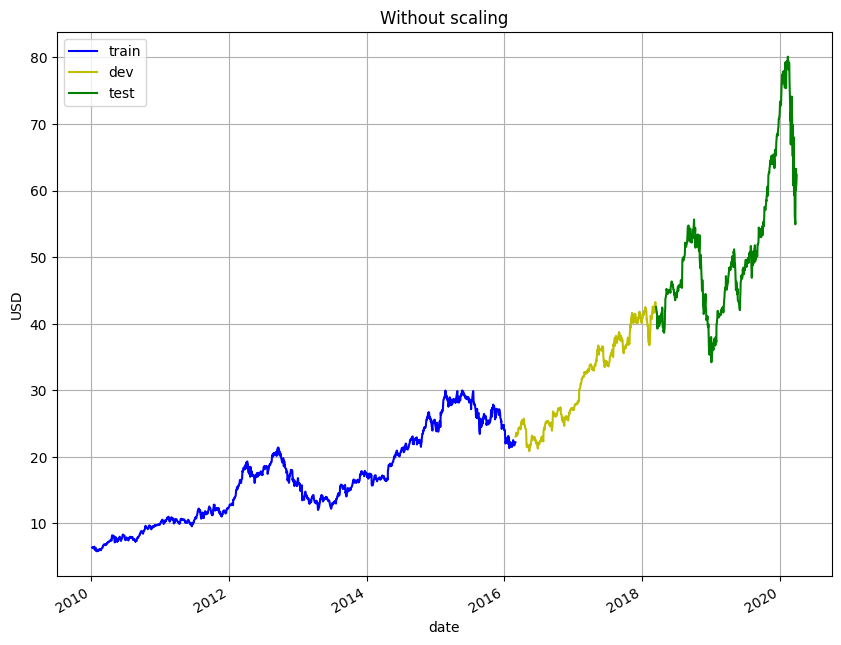

In [29]:
rcParams['figure.figsize'] = 10, 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Plot adjusted close with scaling over time for train, validate and test setes

Text(0.5, 1.0, 'With scaling')

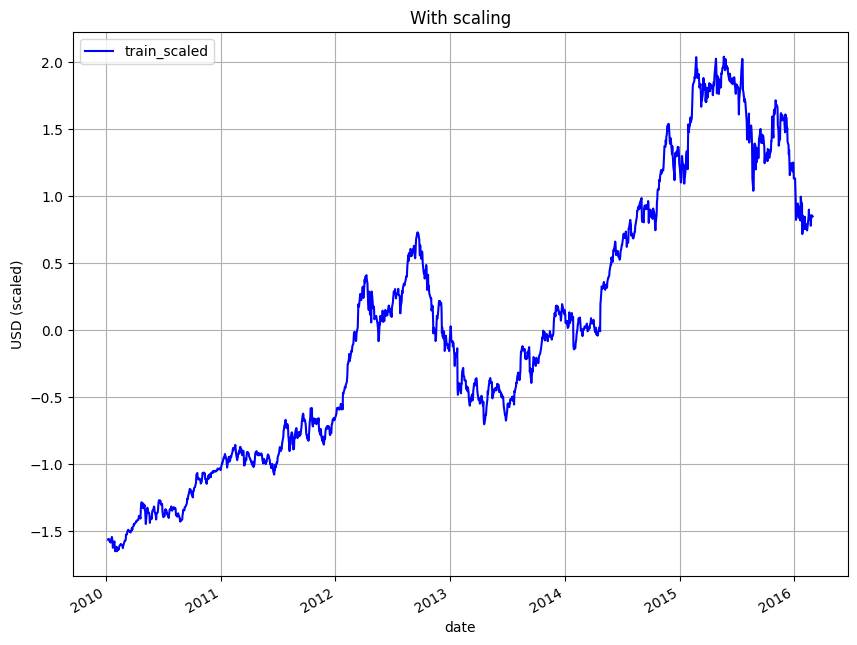

In [30]:
rcParams['figure.figsize'] = 10, 8
ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Create the model

the model have been built by using default hyperparameters from gloabale variables. later on, they will be changeed when tuning model.
by calling **fit()** function, the model is going to be trined on train data.

In [31]:
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train model
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Prediction on train set

The prediction is on train set and evaluate model by using MSE,MAE,RMSE and MAPE mitrices.

In [32]:
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]
# Calculate MSE,MAE,RMSE,MAPE, and Accurecy
print("MSE on train set = %0.3f" % mean_squared_error(y_train, est))
print("MAE on train set = %0.3f" % mean_absolute_error(y_train, est))
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))
acu=r2_score(y_train, est)
print("Accurecy on dev set = %0.3f%%" % acu)

MSE on train set = 0.050
MAE on train set = 0.159
RMSE on train set = 0.224
MAPE on train set = 0.995%
Accurecy on dev set = 0.999%


Plot adjusted close prdiction

Text(0.5, 1.0, 'Without scaling')

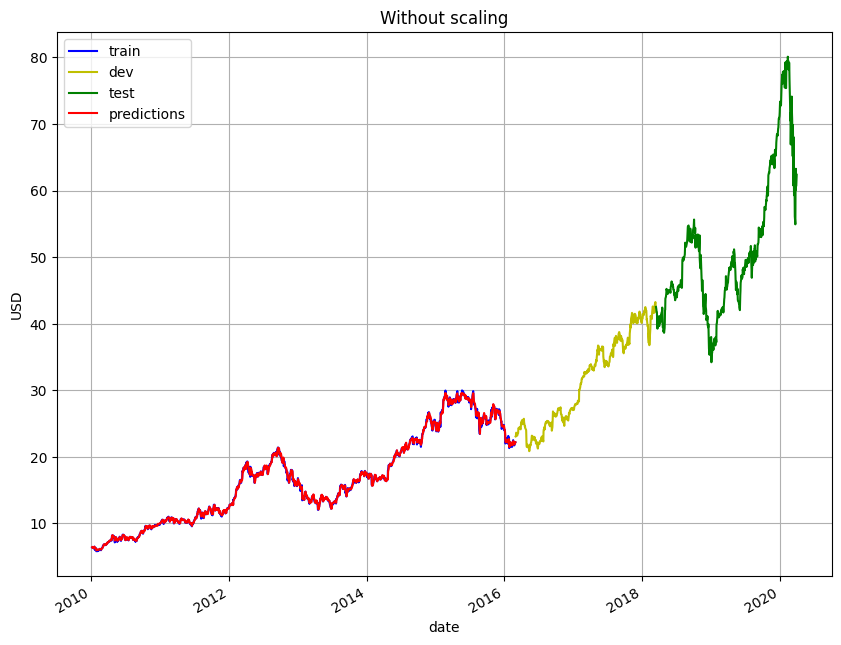

In [33]:
rcParams['figure.figsize'] = 10, 8 
est_df = pd.DataFrame({'est': est,'date': train['date']})
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

Do prediction on validation (dev) set and evaluate model by using RMSE and MAPE

In [34]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']
# Calculate MSE,MAE,RMSE,MAPE
mse_bef_tuning = mean_squared_error(y_cv, cv['est'])
print("MSE on dev set = %0.3f" % mse_bef_tuning)
mae_bef_tuning = mean_absolute_error(y_cv, cv['est'])
print("MAE on dev set = %0.3f" % mae_bef_tuning)
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)
acu=r2_score(y_cv, cv['est'])
print("Accurecy on dev set = %0.3f%%" % acu)

MSE on dev set = 0.159
MAE on dev set = 0.273
RMSE on dev set = 0.398
MAPE on dev set = 0.872%
Accurecy on dev set = 0.996%


Plot adjusted close for validation (dev) set

Text(0, 0.5, 'USD')

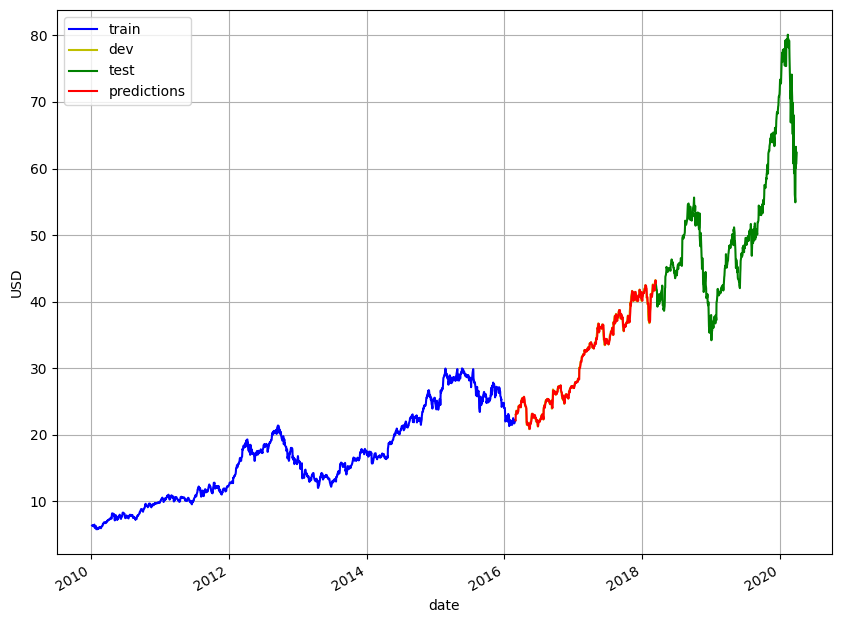

In [35]:
rcParams['figure.figsize'] = 10, 8 
est_df = pd.DataFrame({'est': cv['est'], 'y_cv': y_cv,'date': cv['date']})
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Zoom in predictions for validation set

Text(0.5, 1.0, 'Zoom in to validation set')

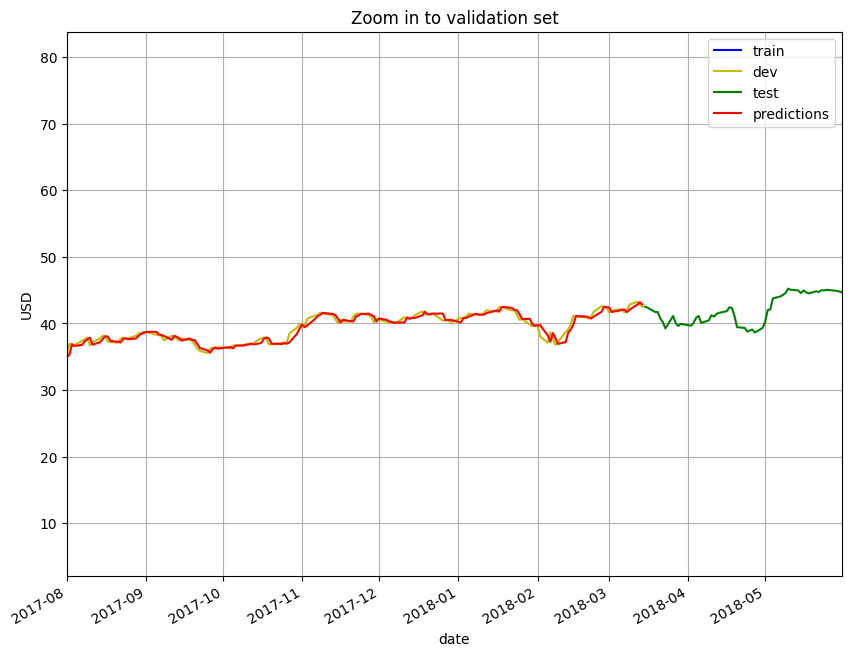

In [36]:
rcParams['figure.figsize'] = 10, 8 
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 8, 1), date(2018, 5, 31)])
ax.set_title("Zoom in to validation set")

# View importance scores of the features 

The model can show importance of featuers. higher score has high reletive to predictor.

In [37]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('volume_lag_3', 0.00026511523),
 ('range_hl_lag_1', 0.00027456717),
 ('range_hl_lag_2', 0.00032187317),
 ('range_hl_lag_3', 0.0003271315),
 ('volume_lag_1', 0.0003353371),
 ('volume_lag_2', 0.00034407162),
 ('range_oc_lag_1', 0.00034907737),
 ('adj_close_lag_2', 0.04649949),
 ('adj_close_lag_3', 0.05213798),
 ('adj_close_lag_1', 0.8986869)]

In [38]:
ff=pd.DataFrame(imp[-10:])
ff.columns=['features','importance']
ff

,features,importance
0,volume_lag_3,0.000265
1,range_hl_lag_1,0.000275
2,range_hl_lag_2,0.000322
3,range_hl_lag_3,0.000327
4,volume_lag_1,0.000335
5,volume_lag_2,0.000344
6,range_oc_lag_1,0.000349
7,adj_close_lag_2,0.046499
8,adj_close_lag_3,0.052138
9,adj_close_lag_1,0.898687


In [47]:
fig = px.bar(x=ff['features'],y=ff['importance'])
fig.show()

In [40]:
# f=pd.DataFrame(imp,columns=['featuer','importance'])
# f.plot(x='featuer',y='importance',kind='bar')

# Tuning XGBoost for param n_estimators and max_depth
- n_estimators = range(10, 310, 10)
- max_depth= [2, 3, 4, 5, 6, 7, 8, 9]

In [41]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)
param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]
error_rate = {param_label: [] , param2_label: [], 'mse': [],'mae': [],'rmse': [], 'mape_pct': []}
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        mse,mae,rmse, mape, _ ,_= model_train_pred_eval(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # get results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['mse'].append(mse)
        error_rate['mae'].append(mae)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
error_rate = pd.DataFrame(error_rate)
error_rate  

  0%|          | 0/30 [00:00<?, ?it/s]

,n_estimators,max_depth,mse,mae,rmse,mape_pct
0,10,2,0.170052,0.284498,0.412373,0.913012
1,10,3,0.169699,0.284883,0.411945,0.914162
2,10,4,0.169690,0.284827,0.411934,0.913925
3,10,5,0.170051,0.284937,0.412372,0.914386
4,10,6,0.170062,0.284834,0.412385,0.914056
...,...,...,...,...,...,...
235,300,5,0.161527,0.276385,0.401904,0.883315
236,300,6,0.159808,0.274212,0.399760,0.875349
237,300,7,0.159398,0.273585,0.399247,0.872453
238,300,8,0.158869,0.273067,0.398584,0.870641


### optimum value for n_estimators and max_depth

In [42]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print(f"optimum params for n_estimators= {n_estimators_opt} ,max_depth={max_depth_opt} ")
n_estimators_opt, max_depth_opt

min RMSE = 0.398
optimum params for n_estimators= 170 ,max_depth=2 


(170, 2)

### Get MAPE for optimum value for n_estimators and max_depth 

In [43]:
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 0.869%
optimum params = 


(170, 2)

# Tuning XGBoost for param learning_rate and min_child_weight
- learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
- min_child_weight= range(5, 21, 1)

In [44]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)
error_rate = {param_label: [] , param2_label: [], 'mse': [],'mae': [],'rmse': [], 'mape_pct': []}
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        mse,mae,rmse, mape, _,_ = model_train_pred_eval(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['mse'].append(mse)
        error_rate['mae'].append(mae)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate 

  0%|          | 0/7 [00:00<?, ?it/s]

,learning_rate,min_child_weight,mse,mae,rmse,mape_pct
0,0.001,5,0.232986,0.335383,0.482686,1.083197
1,0.001,6,0.232986,0.335383,0.482686,1.083197
2,0.001,7,0.232986,0.335383,0.482686,1.083197
3,0.001,8,0.232986,0.335383,0.482686,1.083197
4,0.001,9,0.232986,0.335383,0.482686,1.083197
...,...,...,...,...,...,...
107,0.300,16,0.156361,0.271145,0.395425,0.864018
108,0.300,17,0.156344,0.271214,0.395403,0.864670
109,0.300,18,0.156048,0.270958,0.395029,0.863658
110,0.300,19,0.155979,0.270818,0.394942,0.863004


### Plot performance versus params

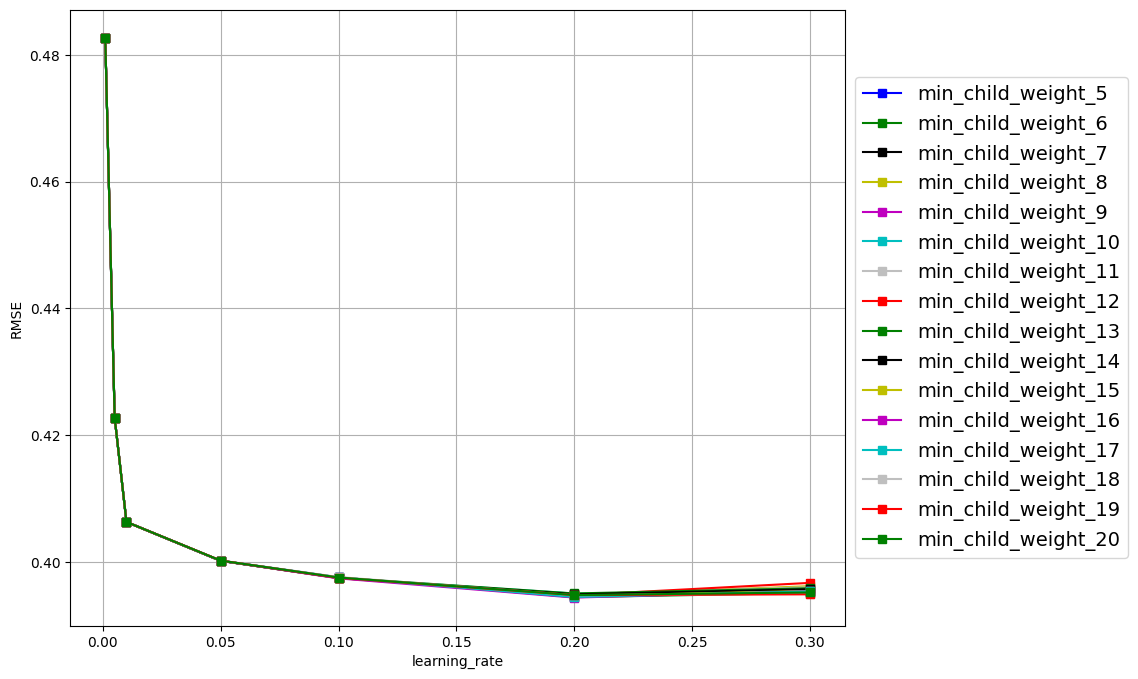

In [45]:
rcParams['figure.figsize'] = 10, 8 
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))
ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))

# Get optimum value for learning_rate and min_child_weight

In [46]:
# get RMSE for learning_rate and min_child_weight
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 0.394
optimum params = 


(0.2, 16)

# RMSE is used to decide the final optimum params to use

In [47]:
# get MAPE for learning_rate and min_child_weight
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 0.863%
optimum params = 


(0.3, 19)

# Tuning XGBoost for subsample and gamma


In [48]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
error_rate = {param_label: [] , param2_label: [], 'mse': [],'mae': [],'rmse': [], 'mape_pct': []}
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        mse,mae,rmse, mape, _,_ = model_train_pred_eval(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['mse'].append(mse)
        error_rate['mae'].append(mae)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate   

  0%|          | 0/10 [00:00<?, ?it/s]

,subsample,gamma,mse,mae,rmse,mape_pct
0,0.1,0.1,0.190108,0.304790,0.436014,0.977389
1,0.1,0.2,0.190251,0.304700,0.436178,0.976662
2,0.1,0.3,0.189118,0.303568,0.434877,0.972797
3,0.1,0.4,0.189538,0.303210,0.435360,0.970976
4,0.1,0.5,0.189354,0.303035,0.435149,0.970433
...,...,...,...,...,...,...
95,1.0,0.6,0.155672,0.271269,0.394553,0.865124
96,1.0,0.7,0.155795,0.271332,0.394709,0.865323
97,1.0,0.8,0.155692,0.271294,0.394578,0.865245
98,1.0,0.9,0.155792,0.271348,0.394704,0.865391


# Plot performance versus params

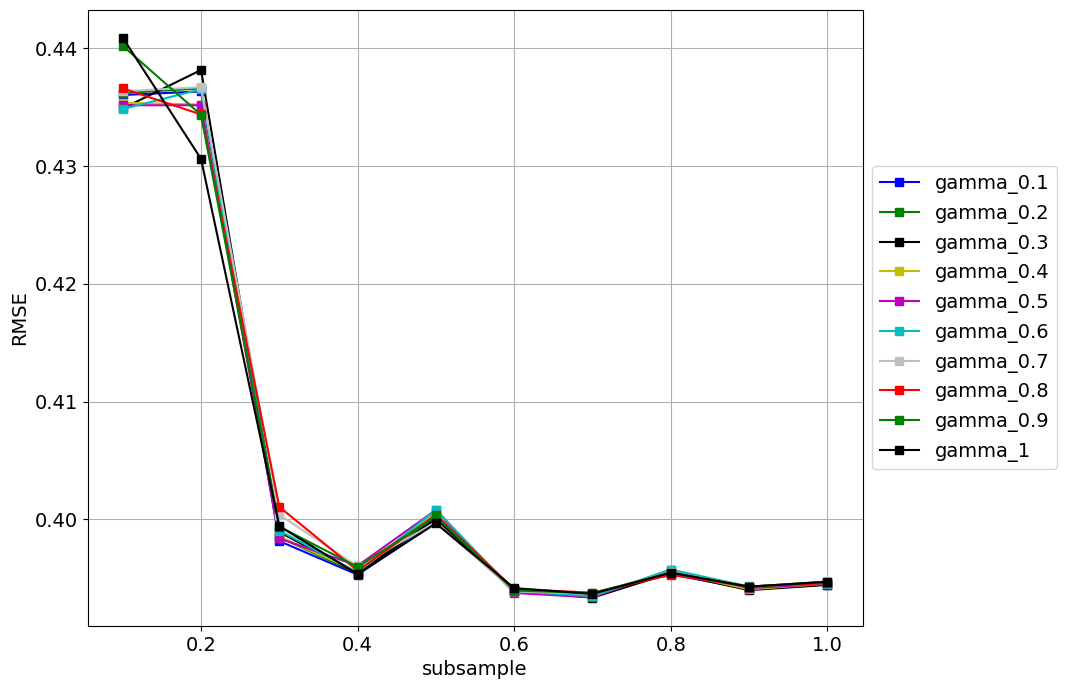

In [50]:
rcParams['figure.figsize'] = 10, 8 
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))
ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) 

### optimum value for subsample and gamma

In [51]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 0.393
optimum params = 


(0.7, 0.3)

### Get MAPE for optimum value for subsample and gamma

In [52]:
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 0.862%
optimum params = 


(0.9, 0.4)

# Tuning XGBoost for colsample_bytree and colsample_bylevel


In [53]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
error_rate = {param_label: [] , param2_label: [], 'mse': [],'mae': [],'rmse': [], 'mape_pct': []}
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        mse,mae,rmse, mape, _,_ = model_train_pred_eval(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['mse'].append(mse)
        error_rate['mae'].append(mae)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate

  0%|          | 0/6 [00:00<?, ?it/s]

,colsample_bytree,colsample_bylevel,mse,mae,rmse,mape_pct
0,0.5,0.5,0.311720,0.392951,0.558319,1.264555
1,0.5,0.6,0.311720,0.392951,0.558319,1.264555
2,0.5,0.7,0.285441,0.378926,0.534267,1.217989
3,0.5,0.8,0.285441,0.378926,0.534267,1.217989
4,0.5,0.9,0.258131,0.355045,0.508066,1.140715
5,0.5,1.0,0.259104,0.356912,0.509023,1.148927
6,0.6,0.5,0.271420,0.362686,0.520980,1.166883
7,0.6,0.6,0.251155,0.347535,0.501154,1.117218
8,0.6,0.7,0.251155,0.347535,0.501154,1.117218
9,0.6,0.8,0.237071,0.338496,0.486900,1.088036


### Plot performance versus params

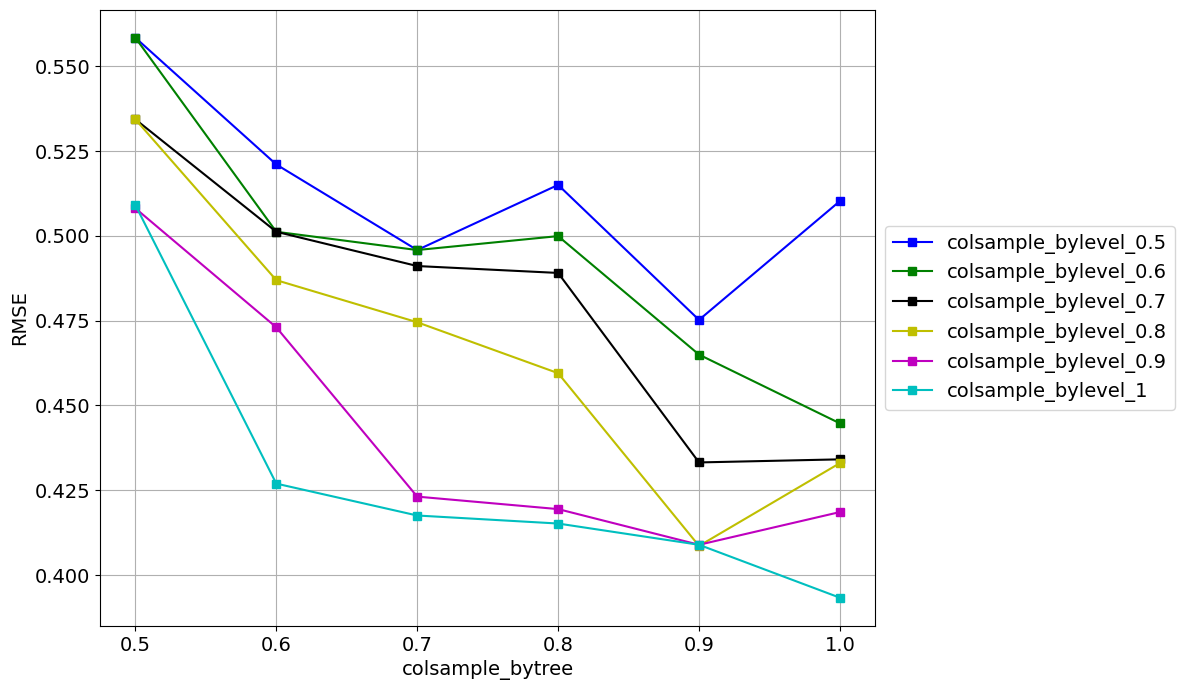

In [54]:
rcParams['figure.figsize'] = 10, 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))
ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))

### Get optimum value for colsample_bytree and colsample_bylevel

In [55]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 0.393
optimum params = 


(1.0, 1.0)

### Get MAPE of optimum value for colsample_bytree and colsample_bylevel

RMSE is used to decide the final optimum params to use

In [56]:
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 0.862%
optimum params = 


(1.0, 1.0)

# Tuned all params


In [57]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,170.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.200
3,min_child_weight,1.000,16.000
4,subsample,1.000,0.700
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.300
8,rmse,0.398,0.393
9,mape_pct,0.872,0.862


# FINAL MODEL after get optimum params values


In [58]:
mse,mae,rmse, mape,accuracy, est = model_train_pred_eval(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# get MSE,MAE,RMSE,MAPE and Accuracy
print("MSE on test set = %0.3f" % mse)
print("MAE on test set = %0.3f" % mae)
print("RMSE on test set = %0.3f" % rmse)
print("MAPE on test set = %0.3f%%" % mape)
print('Accuracy score=%.3f'%(accuracy))

MSE on test set = 1.493
MAE on test set = 0.753
RMSE on test set = 1.222
MAPE on test set = 1.436%
Accuracy score=0.987


# Plot the predictions adjusted close for testing set

Text(0, 0.5, 'USD')

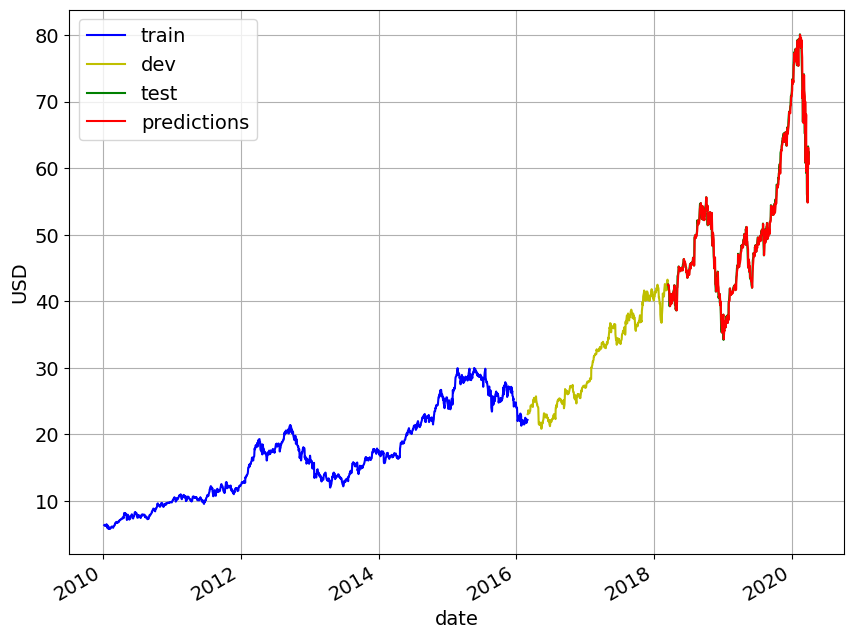

In [59]:
rcParams['figure.figsize'] = 10, 8 

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set predictions')

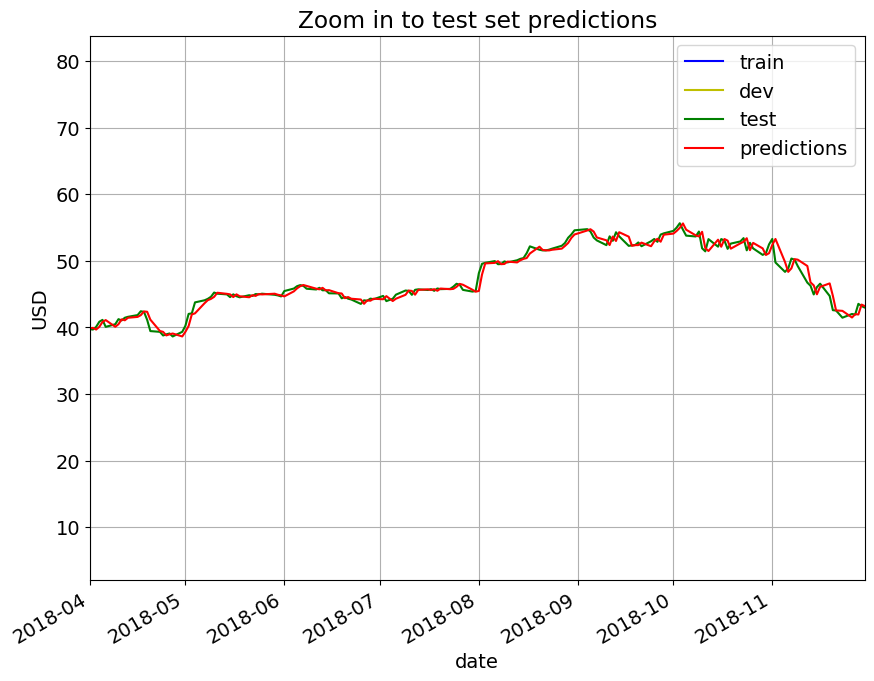

In [60]:
rcParams['figure.figsize'] = 10, 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 1), date(2018, 11, 30)])
ax.set_title("Zoom in to test set predictions")

(17644.0, 17858.0)

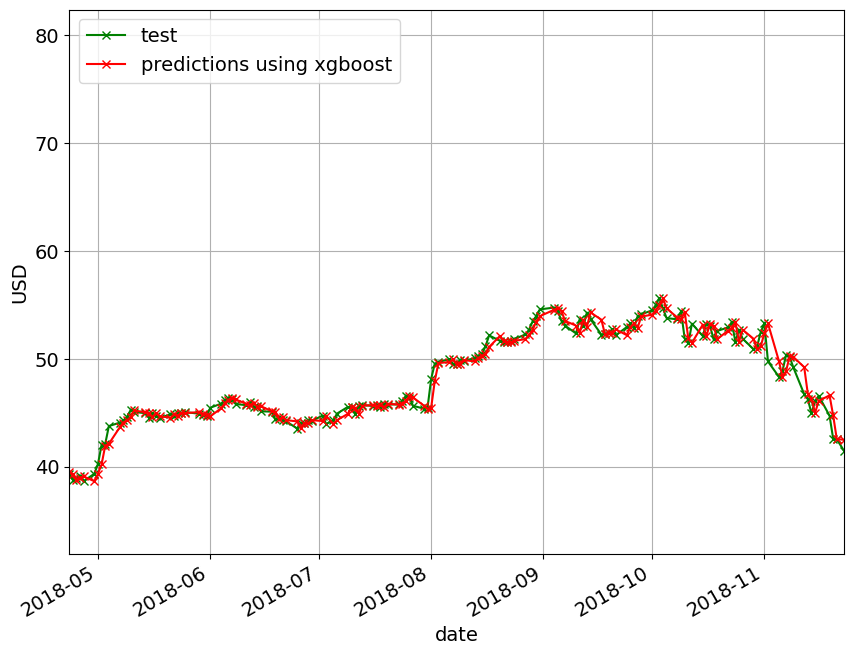

In [61]:
rcParams['figure.figsize'] = 10, 8 
matplotlib.rcParams.update({'font.size': 14})
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])

# interactive plot for predictions

In [62]:
fig = go.Figure([go.Scatter(x=test['date'], y=test['adj_close'],name="Test"),
                 go.Scatter(x=est_df['date'], y=est_df['est'],name="Prediction")])
fig.show()

# Random Forest Regression Mode

In [63]:
from numpy import arange
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

## Step 4: Hyperparemater tuning

Hyperparameters are the settings of the model. It is important to have parameters that are adjusted for performance optimization. I set it after training and testing the dataset, before fitting and predicting. Hyperparameters solve the main problem in machine learning which is overfitting. I used random search cross-validation in this project.

    The hyperparameters in the random forest model are either used to increase the predictive power of the model or to make the model faster

For a random forest regression model, the best parameters to consider are:

    - n_estimators: number of trees in the forest
    - max_depth: maximum depth in a tree
    - min_samples_split:  minimum number of data points before the sample is split
    - min_samples_leaf:  minimum number of leaf nodes that are required to be sampled
    - bootstrap: sampling for data points, true or false
    - random_state: generated random numbers for the random forest.

In [64]:
grid_rf_rfr = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
model_rfr=RandomForestRegressor()
rscv_rfr = RandomizedSearchCV(estimator=model_rfr, param_distributions=grid_rf_rfr, cv=3, n_jobs=-1, verbose=2, n_iter=200)
# rscv_fit = rscv.fit(x_train, y_train)
rscv_fit_rfr = rscv_rfr.fit(X_train_scaled, y_train_scaled)
best_parameters_rfr = rscv_fit_rfr.best_params_
print(best_parameters_rfr)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5, 'bootstrap': False}


In [66]:
model_rfr = RandomForestRegressor(random_state=1,n_estimators=500,  min_samples_split=2, 
                                  min_samples_leaf=5, max_depth=5, bootstrap=False)
# train model
model_rfr.fit(X_train_cv_scaled, y_train_cv_scaled)

RandomForestRegressor(bootstrap=False, max_depth=5, min_samples_leaf=5,
                      n_estimators=500, random_state=1)

In [67]:
# do prediction on test set
predict_rfr = model_rfr.predict(X_sample_scaled)

In [68]:
# Do scaling for y test set to evaluate RFR model 
test_scaled_rfr = test[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: row_scaling(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled_rfr = pd.concat([test_scaled_rfr, temp], axis=1)
# Now the entire y test set is scaled
temp_rfr = test.apply(lambda row: row_scaling(row['adj_close'], row['adj_close_mean'], row['adj_close_std']), axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

## Statistical metrics and performance evaluation

In [70]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(temp_rfr, predict_rfr), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(temp_rfr, predict_rfr), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(temp_rfr, predict_rfr)), 4))
print("(R^2) Score:", round(metrics.r2_score(temp_rfr, predict_rfr), 4))
print(f'Train Score : {model_rfr.score(X_train_cv_scaled, y_train_cv_scaled) * 100:.2f}% and Test Score : {model_rfr.score(X_sample_scaled, temp_rfr) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict_rfr - temp_rfr)
mape_rfr = 100 * (errors / temp_rfr)
accuracy_rfr = 100 - np.mean(mape_rfr)
# print('Accuracy:', round(accuracy_rfr, 2), '%.')

Mean Absolute Error: 1.7099
Mean Squared Error: 8.0918
Root Mean Squared Error: 2.8446
(R^2) Score: 0.0505
Train Score : 99.80% and Test Score : 5.05% using Random Tree Regressor.
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=1, min_samples_split=9, n_estimators=50, random_state=2; total time=   1.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=11, min_samples_split=9, n_estimators=1000, random_state=30; total time=   9.0s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=9, min_samples_split=10, n_estimators=500, random_state=2; total time=   7.7s
[CV] END bootstrap=False, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=1000, random_state=1; total time=   9.4s
[CV] END bootstrap=False, max_depth=14, min_samples_leaf=3, min_samples_split=10, n_estimators=50, random_state=1; total time=   1.6s
[CV] END bootstrap=False, max_depth=14, min_samples_leaf=9, min_samples_split=10, n_estimators=1000, random_state=1; total time=  26.9s
[CV] END bootstr